# PyData London

### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path

dir = "data/Spark"
files = Path(dir).glob('application_1448006111297_*/*.log')
#files = Path(dir).glob('*/*.log')

split_list = []
for file in files:
    log_data = open(file, 'r')
    new_file = True
    line = next(log_data)
    while True:
        try:
            datetime = pd.to_datetime(line[:17], format='%y/%m/%d %H:%M:%S')
            message  = line[18:-1]
            split_list.append([datetime, message])
            new_file = False
        except:
            if new_file:
                continue
            datetime, message = split_list[-1]
            message += '\n'
            message += line[:-1]
            split_list[-1] = [datetime, message]
        try:
            line = next(log_data)
        except StopIteration:
            break

df = pd.DataFrame(split_list, columns=['datetime', 'message'])

In [4]:
df['indextime'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds()
df.sort_values('indextime',inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.loc[:,["datetime","message"]]

,datetime,message
0,2016-04-07 10:45:21,INFO executor.CoarseGrainedExecutorBackend: Re...
1,2016-04-07 10:45:21,INFO executor.CoarseGrainedExecutorBackend: Re...
2,2016-04-07 10:45:22,INFO spark.SecurityManager: SecurityManager: a...
3,2016-04-07 10:45:22,INFO spark.SecurityManager: Changing modify ac...
4,2016-04-07 10:45:22,INFO spark.SecurityManager: Changing view acls...
...,...,...
118403,2016-04-07 12:22:08,INFO util.ShutdownHookManager: Shutdown hook c...
118404,2016-04-07 12:22:08,INFO util.ShutdownHookManager: Deleting direct...
118405,2016-04-07 12:22:08,INFO util.ShutdownHookManager: Shutdown hook c...
118406,2016-04-07 12:22:08,INFO executor.CoarseGrainedExecutorBackend: Dr...


### Clustering

In [6]:
from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig

config = TemplateMinerConfig()
config.load("../experiment/drain3.ini")
config.profiling_enabled = True
template_miner = TemplateMiner(config=config)

In [7]:
info = df.apply(lambda row: template_miner.add_log_message(row['message']), axis=1)

In [8]:
df['drain_template'] = df.apply(lambda row: template_miner.match(row['message']).get_template(), axis=1)
df['drain_cluster']  = df.apply(lambda row: template_miner.match(row['message']).cluster_id, axis=1)

### Utils

In [9]:
def plot_count(pdf, nodes=[], dt=60):
    """
    pdf Data Frame
    nodes to plot
    dt time granularity
    """
    t_min = df['indextime'].min()
    t_max = df['indextime'].max()
    trange = np.arange(t_min,t_max,dt)
    intensity = [np.zeros(len(trange)) for _ in nodes]
    
    for i, node in enumerate(nodes):
        filter = pdf['drain_cluster'] == node
        ticks = pdf[filter]['indextime'].values
        for tick in ticks:
            idx = int(1.*tick / dt)
            intensity[i][idx] += 1            
    
    fig, axes = plt.subplots(len(nodes), 1, figsize=(16, 8), sharex=True)
    if len(nodes) == 1:
        axes = [axes]
    for i,node in enumerate(nodes):
        axes[i].step(trange, intensity[i], label="Cluster #"+str(node))
        axes[i].set_xlabel("Time [s]")
        axes[i].set_ylabel("Count in "+str(dt)+"s")
        axes[i].legend()
    fig.show()
    fig.savefig("PyData_count.png")

In [10]:
def plot_intensity(pdf, decay, mu, beta, nodes=[],dt=1):
    dt = 1
    t_min = pdf['indextime'].min()
    t_max = pdf['indextime'].max()
    trange = np.arange(t_min,t_max,dt)
    
    clusters = [] # clusters[t] list of clusters that in time [t,t+dt] has ticks
    idx = 0
    for t in trange:
        clusters.append([])
        while True:
            if idx >= len(pdf['indextime']):
                break
            if pdf['indextime'][idx] >= t + dt:
                break
            else:
                clusters[-1].append(pdf['drain_cluster'][idx])
                idx += 1
    
    intensity = [[0] for _ in nodes]
    for ti, t in enumerate(trange):
        kernels = [0 for _ in nodes]
        for i, node in enumerate(nodes):
            kernels[i] = intensity[i][-1] * np.exp(-decay * dt)
            kernels[i] += decay * np.sum([beta[node,j] for j in clusters[ti]])
            intensity[i].append(mu[node] + kernels[i])
    
    for i, node in enumerate(nodes):
        intensity[i] = intensity[i][1:]
    
    fig, axes = plt.subplots(len(nodes), 1, figsize=(16, 8), sharex=True)
    if len(nodes) == 1:
        axes = [axes]
    for i, node in enumerate(nodes):
        axes[i].plot(trange, intensity[i], label="Cluster #"+str(node))
        axes[i].set_title("Intensity of cluster #"+str(node))
        axes[i].set_xlabel("Time [s]")
        axes[i].set_ylabel("Intensity λ(t)")
        axes[i].legend()
    #axes[0].set_xlim([1350, 1500]) #Zoom in
    fig.show()
    fig.savefig("PyData_Intensity.png")

In [40]:
%matplotlib inline

### Cluster Cardinality

As a result of clustering 

In [12]:
df.loc[:,["indextime","message","drain_template","drain_cluster"]]

,indextime,message,drain_template,drain_cluster
0,0.0,INFO executor.CoarseGrainedExecutorBackend: Re...,INFO executor.CoarseGrainedExecutorBackend: Re...,1
1,0.0,INFO executor.CoarseGrainedExecutorBackend: Re...,INFO executor.CoarseGrainedExecutorBackend: Re...,1
2,1.0,INFO spark.SecurityManager: SecurityManager: a...,INFO spark.SecurityManager: SecurityManager: a...,2
3,1.0,INFO spark.SecurityManager: Changing modify ac...,INFO spark.SecurityManager: Changing modify ac...,3
4,1.0,INFO spark.SecurityManager: Changing view acls...,INFO spark.SecurityManager: Changing view acls...,4
...,...,...,...,...
118403,5807.0,INFO util.ShutdownHookManager: Shutdown hook c...,INFO util.ShutdownHookManager: Shutdown hook c...,22
118404,5807.0,INFO util.ShutdownHookManager: Deleting direct...,INFO util.ShutdownHookManager: Deleting direct...,40
118405,5807.0,INFO util.ShutdownHookManager: Shutdown hook c...,INFO util.ShutdownHookManager: Shutdown hook c...,22
118406,5807.0,INFO executor.CoarseGrainedExecutorBackend: Dr...,INFO executor.CoarseGrainedExecutorBackend: Dr...,23


In [13]:
n_nodes = df['drain_cluster'].nunique()
t_min = df['indextime'].min()
t_max = df['indextime'].max()
print(f"Founded {n_nodes} clusters in time range [{t_min},{t_max}]")

Founded 203 clusters in time range [0.0,5807.0]


In [14]:
drain_clusters = df.groupby(['drain_cluster'])['drain_cluster'].count().sort_values(ascending=False)
display(drain_clusters.head(10))

drain_cluster
103    6881
28     6868
32     6868
30     6271
29     6270
102    6136
27     5850
26     5850
38     5842
99     5719
Name: drain_cluster, dtype: int64

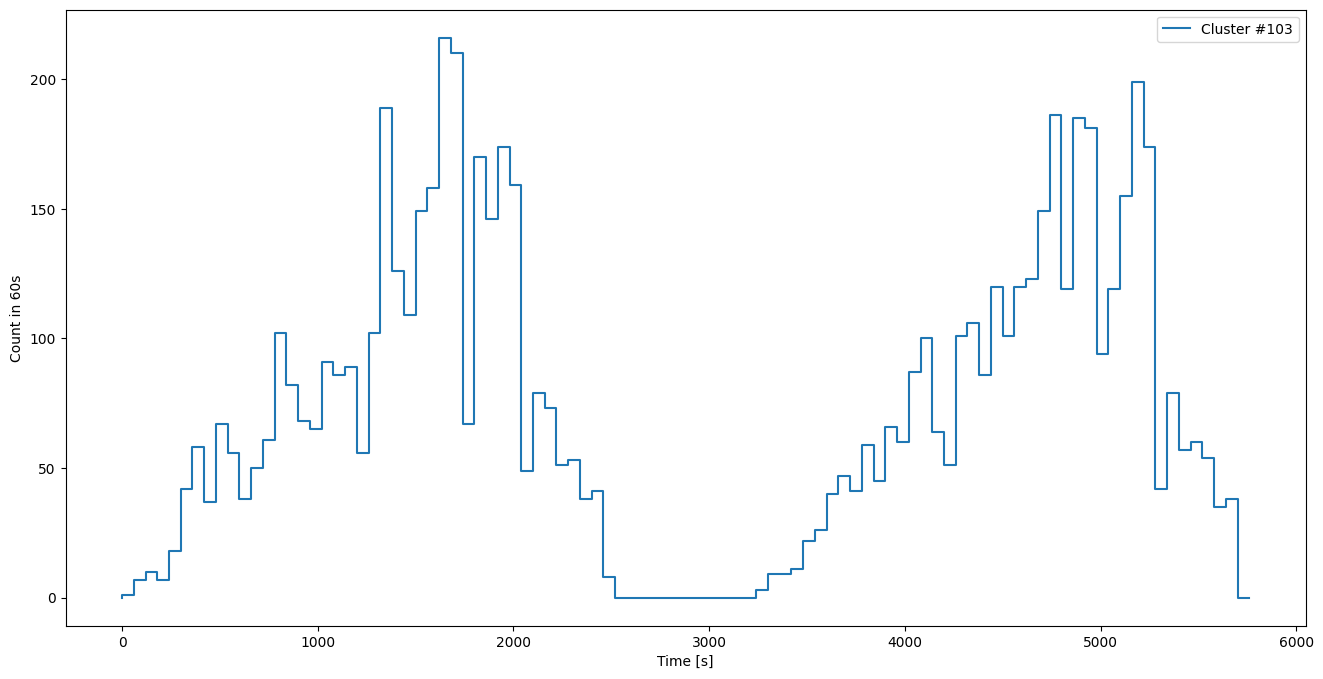

In [43]:
#nodes = [99,97] # Another example of correlation
#nodes = [124,179] # The most correlated clusters
nodes = [103] # The bigest cluster 
plot_count(df,nodes,dt=60)

### Temporal correlation

See blog by Steven Morse 

https://stmorse.github.io/journal/Hawkes-python.html 

He wrote his own library, and after that he made "a discovery":

"Tick is a Python library for statistical learning of point processes, with some additional optimization toolkit tools as well. This library was recently brought to my attention, but from what I can tell it is likely the best of the libraries I list here, in terms of completeness and documentation."

https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesADM4.html#tick.hawkes.HawkesADM4

In [44]:
from tick.base import TimeFunction
from tick.hawkes import SimuHawkesExpKernels, SimuHawkesSumExpKernels, SimuHawkesMulti
from tick.hawkes import HawkesExpKern, HawkesADM4, HawkesSumExpKern
from tick.plot import plot_hawkes_kernels, plot_hawkes_kernel_norms, plot_point_process

In [45]:
# Convert drain3 results into tick input format
df['indextime'].values
tmp = [[] for x in range(df['drain_cluster'].max()+1)]
for i, n in enumerate(df['drain_cluster'].values):
    tmp[n].append(df['indextime'].values[i])
timestamps = [np.array(a) for a in tmp]

In [46]:
verbose = True
n_nodes = df['drain_cluster'].nunique()
reg_lvl, reg_ll = 'least-squares', 'likelihood'
reg_ratio = 0.9
C = 1e1
decay = np.log(2)/60 # Provide half time in seconds 
baseline_start = np.zeros(n_nodes)
adjacency_start = np.random.random((n_nodes, n_nodes))
np.fill_diagonal(adjacency_start,0)

# See: https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesADM4.html#tick.hawkes.HawkesADM4
learner = HawkesADM4(decay, verbose=verbose, n_threads = -1, max_iter = 10000, C = C, lasso_nuclear_ratio=reg_ratio)
learner.fit(timestamps)

Launching the solver HawkesADM4...
  n_iter  |    obj    |  rel_obj  | rel_baseline | rel_adjacency
      991 |  1.84e+02 |  4.94e-08 |     2.45e-10 |      9.91e-06
Done solving using HawkesADM4 in 688.5532681941986 seconds


### Cluster Intensity

In [47]:
pd.DataFrame({"i":np.arange(len(learner.baseline)),"value":learner.baseline}).sort_values(by="value",ascending=False).head(5)

,i,value
1,1,6.817795e-04
43,43,1.826474e-04
28,28,1.976263e-323
26,26,1.976263e-323
32,32,1.976263e-323


5e-324


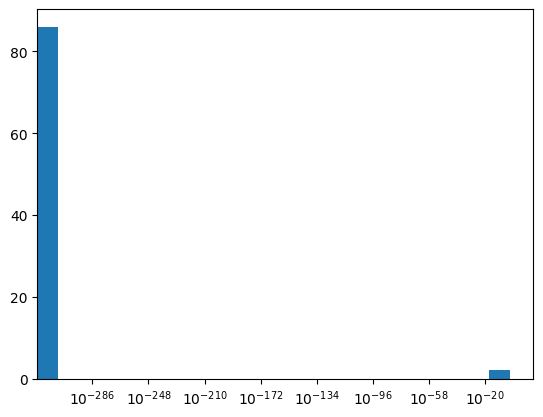

In [48]:
x = learner.baseline.flatten()
x = [v for v in x if v > 0]
print(np.min(x))

logbins = np.logspace(np.log10(np.min(x)),np.log10(np.max(x)),24)
plt.hist(x,bins=logbins)
plt.xscale('log')
plt.show()

In [49]:
adjacency_list = []
for i,array in enumerate(learner.adjacency):
    for j, value in enumerate(array):
        adjacency_list.append([i,j,value])
pd.DataFrame(adjacency_list, columns=["i","j","value"]).sort_values(by="value",ascending=False).head(20)

,i,j,value
25475,124,179,111.104355
20289,99,93,78.634278
20921,102,113,57.177471
20290,99,94,53.391740
20293,99,97,53.321133
20282,99,86,53.269124
20105,98,113,47.942138
14334,70,54,30.355802
13314,65,54,20.351420
13110,64,54,20.351420


5.551115123125783e-16


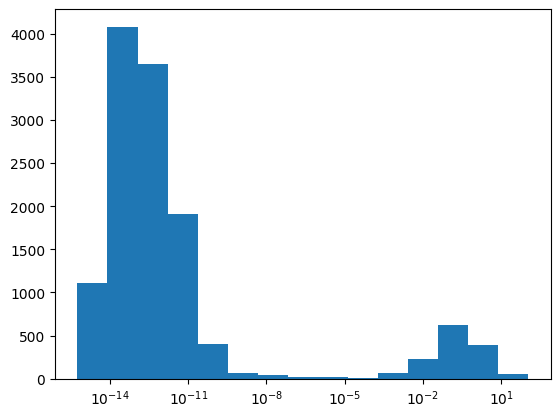

In [50]:
x = learner.adjacency.flatten()
x = [v for v in x if v > 0]
print(np.min(x))

logbins = np.logspace(np.log10(np.min(x)),np.log10(np.max(x)),16)
plt.hist(x,bins=logbins)
plt.xscale('log')
plt.show()

In [51]:
# Set zero to small values
eps = 1e-5

learner_adjacency = learner.adjacency.copy()
learner_baseline = learner.baseline.copy()

learner_baseline[np.abs(learner_baseline) < eps] = 0
learner_adjacency[np.abs(learner_adjacency) < eps] = 0

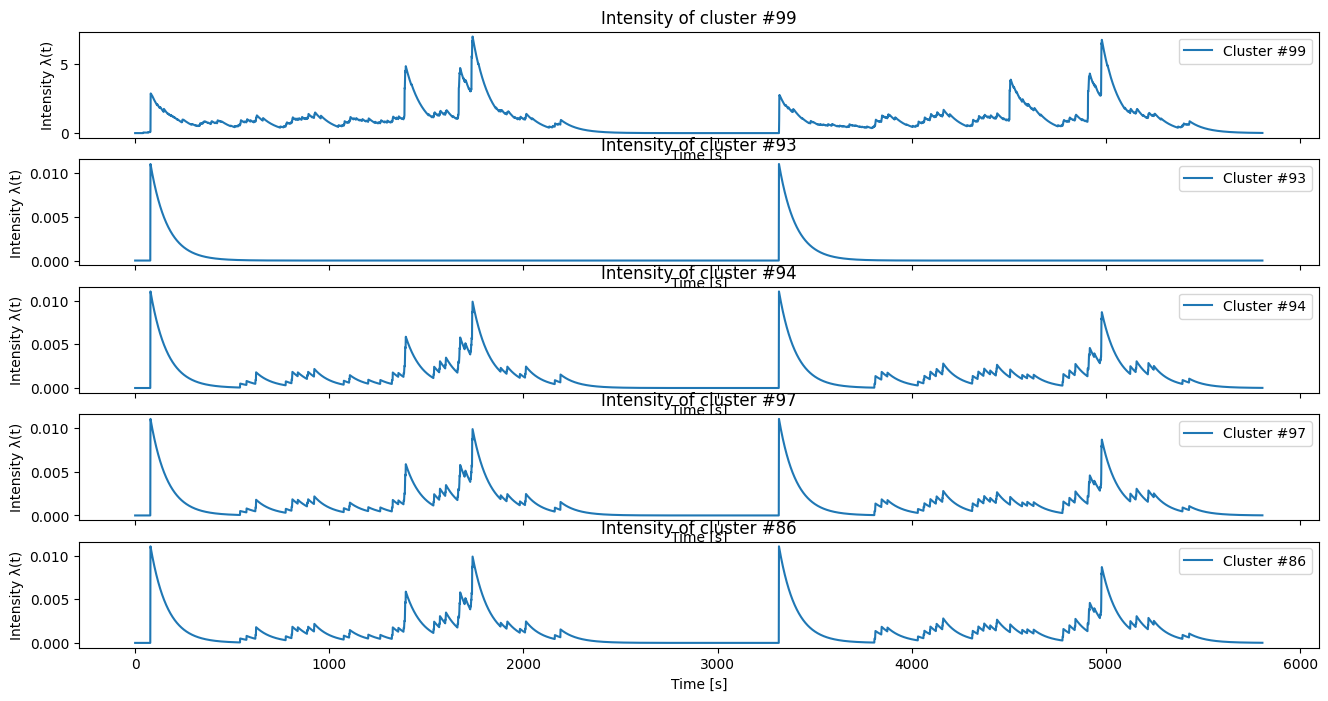

In [91]:
# Plot of corelated clusters
nodes = [124,179] # The most correlated clusters
nodes = [99,93,94,97,86]
#nodes = [103,77] # No correlated clusters
plot_intensity(df,decay,learner_baseline,learner_adjacency, nodes,dt=60)

In [53]:
print("Integration of intensity over time window returns number of occurance in that window.") 
for i in range(len(nodes)):
    print("Cluster",nodes[i],":",drain_clusters[nodes[i]])

Integration of intensity over time window returns number of occurance in that window.
Cluster 179 : 12
Cluster 124 : 4838


### Graph visulization

In [54]:
import networkx as nx

In [55]:
n_nodes = df['drain_cluster'].nunique()
drain_cluster_example = {node:[] for node in np.arange(n_nodes)+1}
for index, row in df.drop_duplicates(subset=['drain_cluster','drain_template']).iterrows():
    drain_cluster_example[row['drain_cluster']].append((row['drain_template'],row['message'][:60]))

In [79]:
DG_full = nx.DiGraph()
DG_full.add_nodes_from([(i, {'msg':drain_cluster_example[i][0][1]}) for i in np.arange(n_nodes)+1])

for i,array in enumerate(learner.adjacency):
    for j, value in enumerate(array):
        DG_full.add_edges_from([(j,i,{'weight' : value})])

print(DG_full.number_of_nodes())
print(DG_full.number_of_edges())

204
41616


Observation 1. Graph has 41616 edges and 204 nodes (203 real and 1 auxaliry)

Observation 2. Graph contains a cycle 
nx.dag_longest_path(DG)

We can limit by choosing the strongest connection. How to set up a threshold?
- Absolut threshold?
- Top x edges for each node?
- Edges that are stronger than x% of the stronges?

In [57]:
edge_value_threshold = 10

DG_top = nx.DiGraph()
DG_top.add_nodes_from([(i, {'msg':drain_cluster_example[i][0][1]}) for i in np.arange(n_nodes)+1])

for i,array in enumerate(learner.adjacency):
    for j, value in enumerate(array):
        if value > edge_value_threshold: # Select only the strong connection
            DG_top.add_edges_from([(j,i,{'weight' : value})])

to_remove = []
for node in DG_top.nodes:
    if DG_top.degree(node) == 0:
        to_remove.append(node)
DG_top.remove_nodes_from(to_remove)

print(DG_top.number_of_nodes())
print(DG_top.number_of_edges())

41
41


In [88]:
node = 124
print("in:\t",[node for node in DG_top.predecessors(node)])
print("out:\t",[node for node in DG_top.successors(node)])

in:	 [101, 154, 155, 179]
out:	 []


In [60]:
#nx.draw_random(DG, **draw_settings)  
#nx.draw_circular(DG, **draw_settings)  
#nx.draw_spectral(DG, **draw_settings)  
#nx.draw_spring(DG, **draw_settings) 

In [61]:
draw_settings = {'with_labels': True, 'width': 0.4, 'node_color':'lightblue', 'node_size': 200, 'font_size':8}

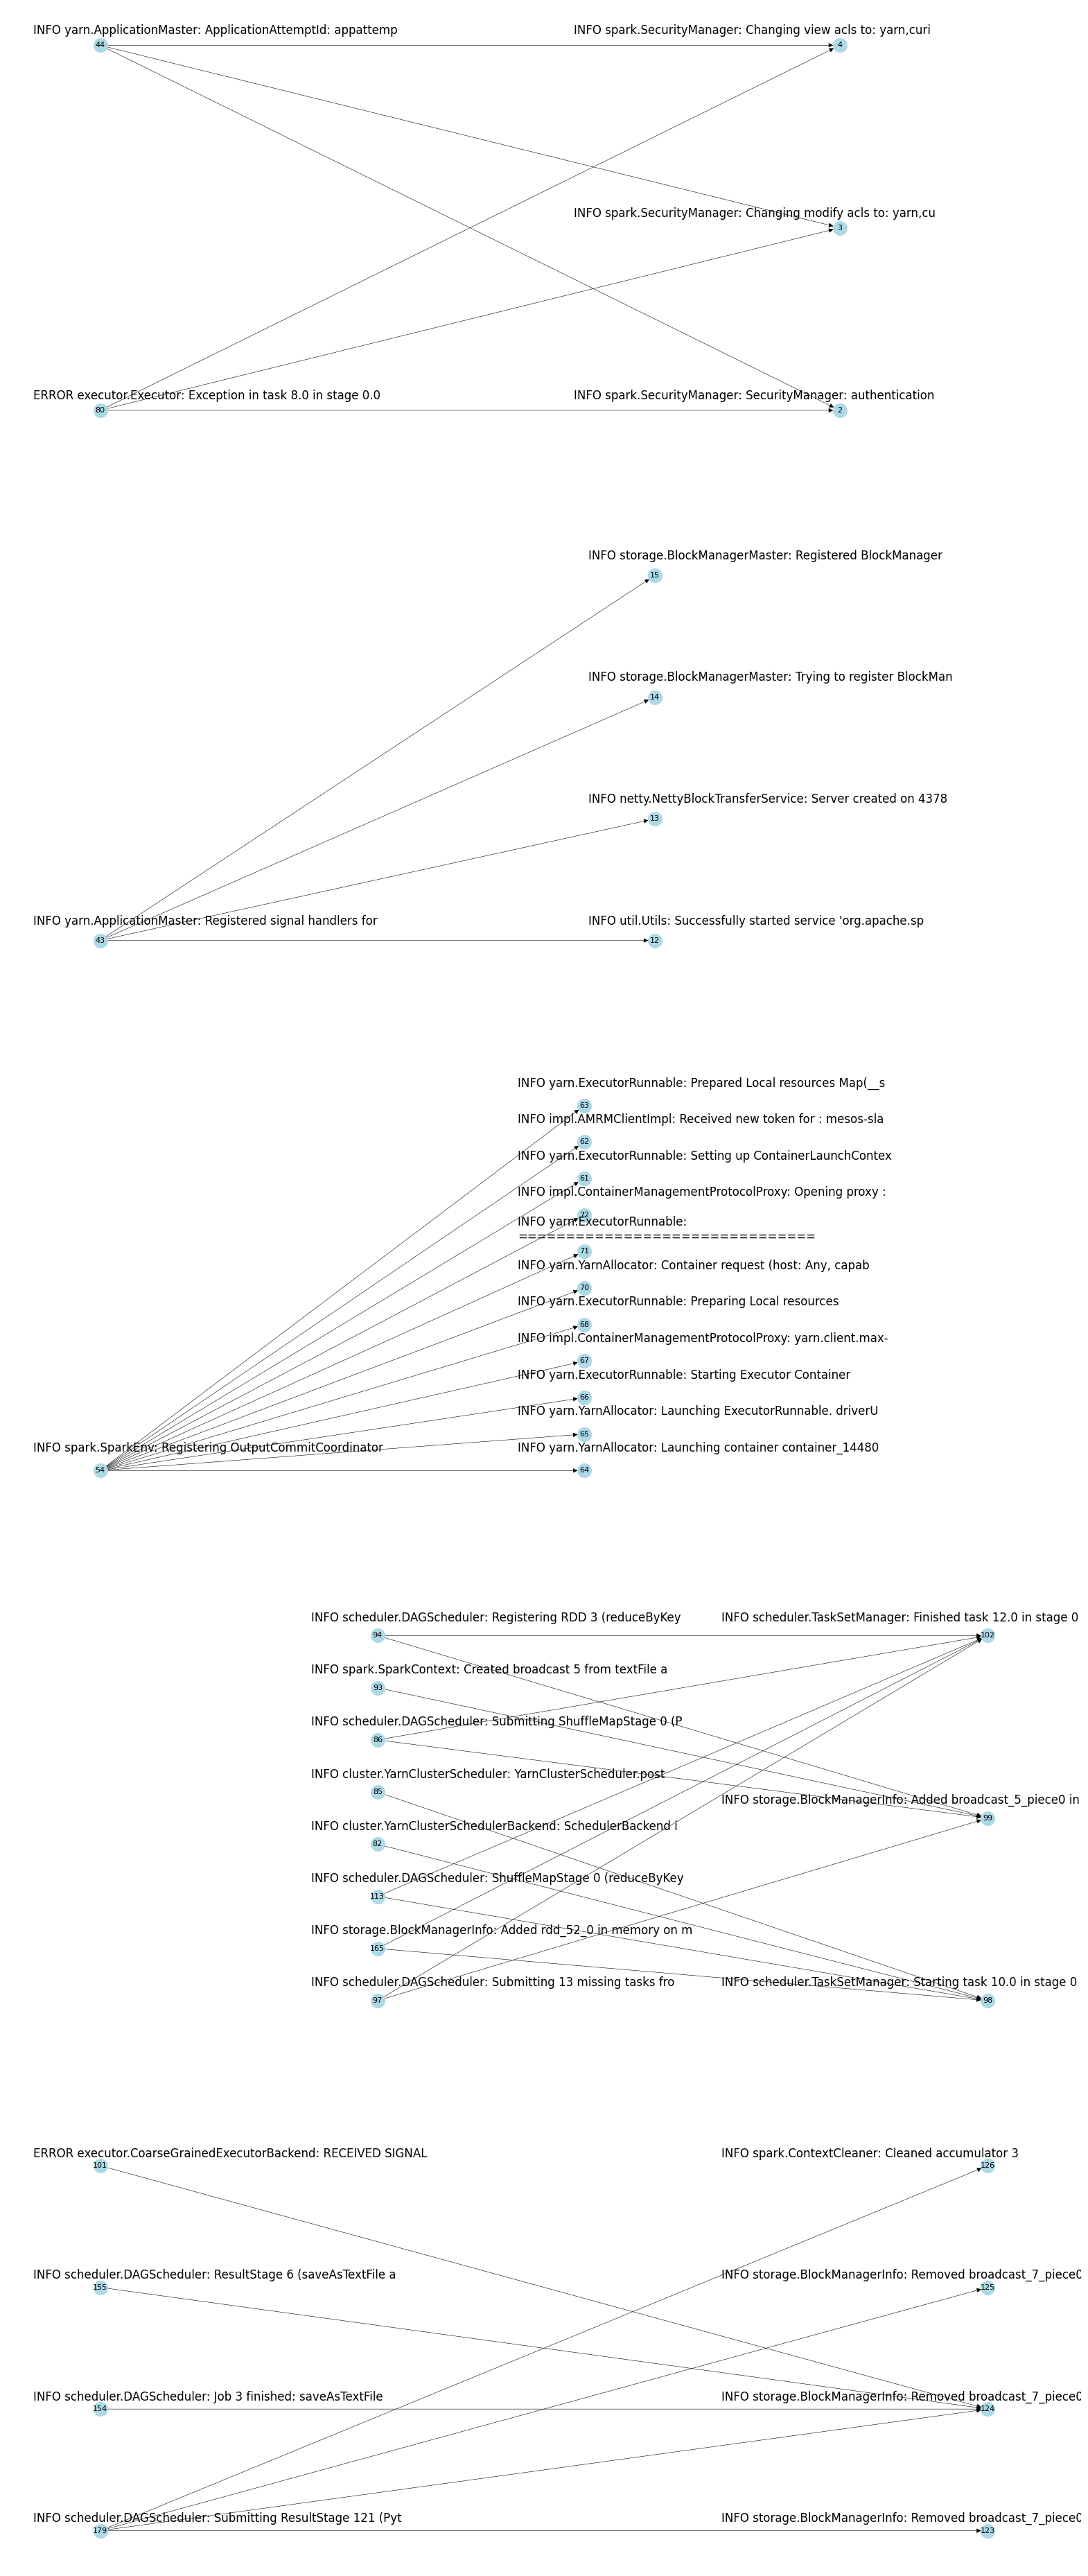

In [82]:
sub_graphs = nx.weakly_connected_components(DG_top)
sub_nodes = []
for sub_graph in sub_graphs:
    sub_nodes.append(sub_graph)

def nudge(pos):
    return {n:(x-0.15 if x < .5 else x-0.6, y + 0.05) for n,(x,y) in pos.items()}

fig, axes = plt.subplots(len(sub_nodes), 1, figsize=(20, 48), sharex=True)
for i, _ in enumerate(sub_nodes):
    G = DG_top.subgraph(sub_nodes[i])
    top = nx.bipartite.sets(G)[0]
    pos = nx.bipartite_layout(G,top)
    types = nx.get_node_attributes(G, 'msg')
    nx.draw(G, pos, ax = axes[i], **draw_settings) 
    nx.draw_networkx_labels(G, pos=nudge(pos), labels=types, horizontalalignment='left', ax=axes[i])
fig.savefig("graphs.png")
fig.show()

In [89]:
#nodes = [99,97,86,94,113,93,165] #Adding broadcast
#nodes = [102,174,175,176,113,165] # Finishing task
#nodes = [98,113,176,175,174,165] # Starting task
nodes = [124,179,188] # Remove broadcast

samples = []
for node in nodes:
    templates = df[df['drain_cluster'] == node]['drain_template'].unique()
    for template in templates:
        samples.append(df[df['drain_template']==template].sample(1,random_state=42).index.values[0])

with pd.option_context('display.max_colwidth', 200):
    display(df.loc[samples].loc[:,['drain_cluster','message']])

,drain_cluster,message
81435,124,"INFO storage.BlockManagerInfo: Removed broadcast_116_piece0 on mesos-slave-13:39924 in memory (size: 4.1 KB, free: 27.1 GB)"
98912,179,"INFO scheduler.DAGScheduler: Submitting ResultStage 206 (PythonRDD[412] at max at IPLoM.py:556), which has no missing parents"
103585,188,INFO spark.ContextCleaner: Cleaned shuffle 2


### Still to explore

In [63]:
edge_value_threshold = 1E-5

DG = nx.DiGraph()
DG.add_nodes_from([(i, {'msg':drain_cluster_example[i][0][1]}) for i in np.arange(n_nodes)+1])

for i,array in enumerate(learner.adjacency):
    for j, value in enumerate(array):
        if value > edge_value_threshold: # Select only the strong connection
            DG.add_edges_from([(j,i,{'weight' : value})])

to_remove = []
for node in DG.nodes:
    if DG.degree(node) == 0:
        to_remove.append(node)
DG.remove_nodes_from(to_remove)

print(DG.number_of_nodes())
print(DG.number_of_edges())

203
1365


In [64]:
filter = df.apply(lambda x: x['message'][:5]=="ERROR", axis=1)
for node in df[filter]['drain_cluster'].unique():
    try:
        print(node,":",[node for node in DG.predecessors(node)])
    except:
        pass

20 : [7, 23, 24, 40, 80, 164, 200, 201]
42 : [24, 80, 81]
80 : [24, 80]
81 : [80]
101 : [92, 93]
